In [99]:
# import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

import scienceplots

plt.style.use(['science', 'grid', 'nature', 'notebook'])

In [100]:
def load_data(path2data):
    with open(path2data, 'r') as f:
        data = f.read()

        # cargo time step
        index_time_step = data.find('time step:')
        index_time_step_end = data.find('\n', index_time_step)
        h = float(data[index_time_step+len('time step:'):index_time_step_end])

        # cargo time_limits:
        index_time_limits = data.find('time limits:')
        index_time_limits_end = data.find('\n', index_time_limits)
        time_limits = data[index_time_limits+len('time limits:'):index_time_limits_end].split(',')
        time_limits = [float(i) for i in time_limits]

        # Cargo estados
        index_start_shape = data.find('shape:')
        index_end_shape = data.find('\n', index_start_shape)
        shape = data[index_start_shape+len('shape:'):index_end_shape].split(',')
        shape = [int(i) for i in shape]

        index_start_n_states = data.find('n_states:')
        index_end_n_states = data.find('\n', index_start_n_states)
        n_states = int(data[index_start_n_states+len('n_states:'):index_end_n_states])

        states = data[index_end_n_states+2:].strip().split('),(')   # separo los estados
        states[-1] = states[-1][:-1]    # saco el ultimo parentesis

        # los paso a numeros complejos de numpy
        res = np.empty(n_states*shape[0]*shape[1], dtype=complex)
        for i, state in enumerate(states):
            state_splited = state.split(',')
            res[i] = complex(float(state_splited[0]), float(state_splited[1]))

        res = res.reshape(n_states, shape[0], shape[1])

        return res, h, time_limits


In [101]:
path2read_xplus = '../results/results_x_plus_relaxation.csv'
path2read_psi_re = '../results/results_psi_relax_exc.csv'
path2read_psi_red = '../results/results_psi_plus_relax_exc_desf.csv'

states_x_plus, h_x_plus, time_limits_x_plus = load_data(path2read_xplus)
states_x_plus_re, h_x_plus_re, time_limits_x_plus_re = load_data(path2read_psi_re)
states_x_plus_red, h_x_plus_red, time_limits_x_plus_red = load_data(path2read_psi_red)

gamma_minus = 0.1
gamma_plus = 0.1
gamma_phi = 0.1
omega_q = 1

/opt/homebrew/Caskroom/miniforge/base/envs/repo/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/envs/repo/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


['$\\text{Re} \\{\\rho_{ij}\\}$', '$\\text{Im}\\{\\rho_{ij}\\}$', 'Analítico']
['$\\text{Re} \\{\\rho_{ij}\\}$', '$\\text{Im}\\{\\rho_{ij}\\}$', 'Analítico']


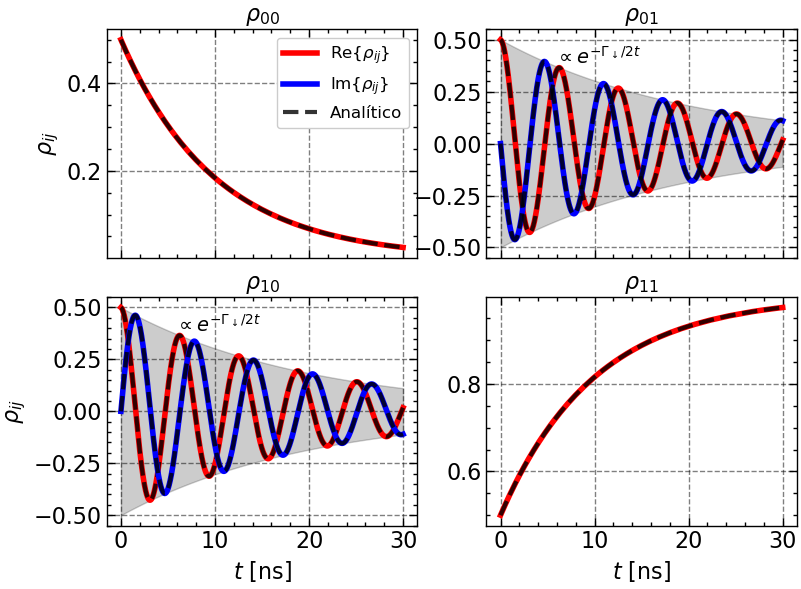

In [141]:
time_axis = np.arange(time_limits_x_plus[0], time_limits_x_plus[1]+h_x_plus, h_x_plus)


up_decay = lambda t, pee: pee * np.exp(-gamma_minus * t)    # Solución analítica para el elemento 0,0 de la matriz de densidad (proba de que este en excitado)
down_decay = lambda t, pee: 1 - up_decay(t, pee)            # Solución analítica para el elemento 1,1 de la matriz de densidad (proba de que este en el estado base)
coherence_decay = lambda t, p01, omega_q: p01 * np.exp(-gamma_minus/2 * t) * np.exp(-1j *omega_q * t) 
p_exc_r = states_x_plus[:,0,0]
p_gnd_r = states_x_plus[:,1,1]
p_01_r = states_x_plus[:, 0,1]
p_10_r = states_x_plus[:, 1,0]


fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

ax[0, 0].plot(time_axis, p_exc_r, color='red', lw=4)
ax[0, 0].plot(time_axis, up_decay(time_axis, p_exc_r[0]), linestyle='--', color='black', alpha=0.8, lw=3)

ax[0, 1].plot(time_axis, p_01_r.real, label=r'$\text{Re} \{\rho_{ij}\}$', color='red', lw=4)
ax[0, 1].plot(time_axis, p_01_r.imag, label=r'$\text{Im}\{\rho_{ij}\}$', color='blue', lw=4)
ax[0, 1].plot(time_axis, coherence_decay(time_axis, p_01_r[0], omega_q).real, label=r'Analítico', linestyle='--', color='black', alpha=0.8, lw=3)
# ax[0, 1].plot(time_axis, coherence_decay(time_axis, p_01_r[0], omega_q).real, label=r'$\exp(-\gamma t/2) \exp(i\omega_q t)$', linestyle='--', color='black', alpha=0.8, lw=3)
ax[0, 1].plot(time_axis, coherence_decay(time_axis, p_01_r[0], omega_q).imag, linestyle='--', color='black', alpha=0.8, lw=3)

envolvente = np.abs(coherence_decay(time_axis, p_01_r[0], omega_q))

ax[0, 1].fill_between(time_axis, -envolvente, envolvente, color='black', alpha=0.2)
ax[0, 1].text(0.22, 0.85, r'$\propto e^{-\Gamma_\downarrow/2 t}$', transform=ax[0,1].transAxes, fontsize=14, color='black')


ax[1, 0].plot(time_axis, p_10_r.real, color='red', lw=4)
ax[1, 0].plot(time_axis, coherence_decay(time_axis, p_10_r[0], omega_q).real, linestyle='--', color='black', alpha=0.8, lw=3)
ax[1, 0].plot(time_axis, p_10_r.imag, color='blue', lw=4)
ax[1, 0].plot(time_axis, coherence_decay(time_axis, p_10_r[0], omega_q).conj().imag,  linestyle='--', color='black', alpha=0.8, lw=3)

envolvente = np.abs(coherence_decay(time_axis, p_10_r[0], omega_q))

ax[1, 0].fill_between(time_axis, -envolvente, envolvente, color='black', alpha=0.2)
ax[1, 0].text(0.22, 0.85, r'$\propto e^{-\Gamma_\downarrow/2 t}$', transform=ax[1,0].transAxes, fontsize=14, color='black')




ax[1, 1].plot(time_axis, p_gnd_r,  color='red', lw=4)
ax[1, 1].plot(time_axis, down_decay(time_axis, p_exc_r[0]), linestyle='--', color='black', alpha=0.8, lw=3)

handles, labels = ax[0, 1].get_legend_handles_labels()
ax[0, 0].legend(handles, labels, fontsize=12)

print(labels)

print(labels)


for i in range(2):
    for j in range(2):
        ax[i, j].set_title(r"$\rho_{%d%d}$" % (i, j))

        if i == 1:
            ax[i, j].set_xlabel(r'$t$ [ns]')
        if j == 0:
            ax[i, j].set_ylabel(r'$\rho_{ij}$')

plt.tight_layout()
plt.savefig('../doc/figures/x_plus_relaxation.pdf', dpi=500)

/opt/homebrew/Caskroom/miniforge/base/envs/repo/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/envs/repo/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


['$\\text{Re} \\{\\rho_{ij}\\}$', '$\\text{Im}\\{\\rho_{ij}\\}$', 'Analítico']
['$\\text{Re} \\{\\rho_{ij}\\}$', '$\\text{Im}\\{\\rho_{ij}\\}$', 'Analítico']


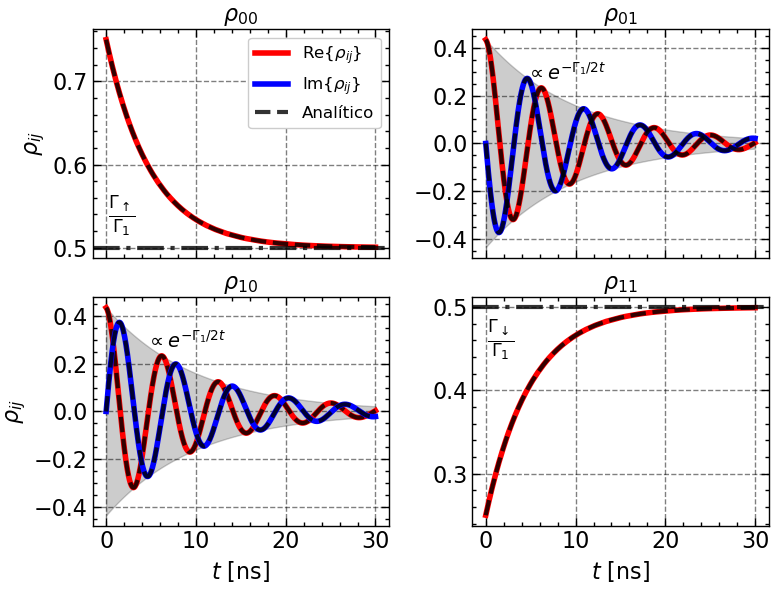

In [131]:
time_axis = np.arange(time_limits_x_plus_re[0], time_limits_x_plus_re[1]+h_x_plus_re, h_x_plus_re)


up_decay = lambda t, pee: pee * np.exp(-gamma_minus * t)    # Solución analítica para el elemento 0,0 de la matriz de densidad (proba de que este en excitado)
down_decay = lambda t, pee: 1 - up_decay(t, pee)            # Solución analítica para el elemento 1,1 de la matriz de densidad (proba de que este en el estado base)
coherence_decay = lambda t, p01, omega_q: p01 * np.exp(-gamma_minus/2 * t) * np.exp(1j *omega_q * t) 

up_decay_term = lambda t, pee, gamma_min, gamma_plus: pee * np.exp(-(gamma_min + gamma_plus) * t) + gamma_plus/(gamma_plus + gamma_minus) * (1 - np.exp(-(gamma_plus + gamma_minus) * t))
down_decay_term = lambda t, pee, gamma_min, gamma_pls: 1 - up_decay_term(t, pee, gamma_min, gamma_pls)

coherence_decay_term = lambda t, p01, omega_q, gamma_minus, gamma_plus: p01 * np.exp(-1j * omega_q * t) * np.exp(-(gamma_minus + gamma_plus)/2 * t) 

p_exc_r = states_x_plus_re[:,0,0]
p_gnd_r = states_x_plus_re[:,1,1]
p_01_r = states_x_plus_re[:, 0,1]
p_10_r = states_x_plus_re[:, 1,0]


fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

ax[0, 0].plot(time_axis, p_exc_r, color='red', lw=4)
ax[0, 0].plot(time_axis, up_decay_term(time_axis, p_exc_r[0], gamma_minus, gamma_plus), linestyle='--', color='black', alpha=0.8, lw=3)
ax[0,0].axhline((gamma_plus/(gamma_plus + gamma_minus)), linestyle='-.', color='black', alpha=0.8, lw=3)
ax[0,0].text(0.05, 0.15, r'$\frac{\Gamma_\uparrow}{\Gamma_1}$', transform=ax[0,0].transAxes, fontsize=18, color='black')


ax[0, 1].plot(time_axis, p_01_r.real, label=r'$\text{Re} \{\rho_{ij}\}$', color='red', lw=4)
ax[0, 1].plot(time_axis, p_01_r.imag, label=r'$\text{Im}\{\rho_{ij}\}$', color='blue', lw=4)
ax[0, 1].plot(time_axis, coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus).real, label=r'Analítico', linestyle='--', color='black', alpha=0.8, lw=3)
ax[0, 1].plot(time_axis, coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus).imag, linestyle='--', color='black', alpha=0.8, lw=3)

envolvente = np.abs(coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus))

ax[0, 1].fill_between(time_axis, -envolvente, envolvente, color='black', alpha=0.2)
ax[0, 1].text(0.18, 0.78, r'$\propto e^{-\Gamma_1/2 t}$', transform=ax[0,1].transAxes, fontsize=14, color='black')


ax[1, 0].plot(time_axis, p_10_r.real, color='red', lw=4)
ax[1, 0].plot(time_axis, coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus).real, linestyle='--', color='black', alpha=0.8, lw=3)
ax[1, 0].plot(time_axis, p_10_r.imag, color='blue', lw=4)
ax[1, 0].plot(time_axis, coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus).conj().imag,  linestyle='--', color='black', alpha=0.8, lw=3)

envolvente = np.abs(coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus))

ax[1, 0].fill_between(time_axis, -envolvente, envolvente, color='black', alpha=0.2)
ax[1, 0].text(0.18, 0.78, r'$\propto e^{-\Gamma_1/2 t}$', transform=ax[1,0].transAxes, fontsize=14, color='black')


ax[1, 1].plot(time_axis, p_gnd_r,  color='red', lw=4)
ax[1, 1].plot(time_axis, down_decay_term(time_axis, p_exc_r[0], gamma_minus, gamma_plus), linestyle='--', color='black', alpha=0.8, lw=3)
ax[1, 1].axhline((gamma_minus/(gamma_plus + gamma_minus)), linestyle='-.', color='black', alpha=0.8, lw=3)
ax[1, 1].text(0.05, 0.78, r'$\frac{\Gamma_\downarrow}{\Gamma_1}$', transform=ax[1,1].transAxes, fontsize=18, color='black')

handles, labels = ax[0, 1].get_legend_handles_labels()
ax[0, 0].legend(handles, labels, fontsize=12)

print(labels)

print(labels)


for i in range(2):
    for j in range(2):
        ax[i, j].set_title(r"$\rho_{%d%d}$" % (i, j))

        if i == 1:
            ax[i, j].set_xlabel(r'$t$ [ns]')
        if j == 0:
            ax[i, j].set_ylabel(r'$\rho_{ij}$')

plt.tight_layout()
plt.savefig('../doc/figures/psi_relx_exc.pdf', dpi=500)

/opt/homebrew/Caskroom/miniforge/base/envs/repo/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/envs/repo/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


['$\\text{Re} \\{\\rho_{ij}\\}$', '$\\text{Im}\\{\\rho_{ij}\\}$', 'Analítico']
['$\\text{Re} \\{\\rho_{ij}\\}$', '$\\text{Im}\\{\\rho_{ij}\\}$', 'Analítico']


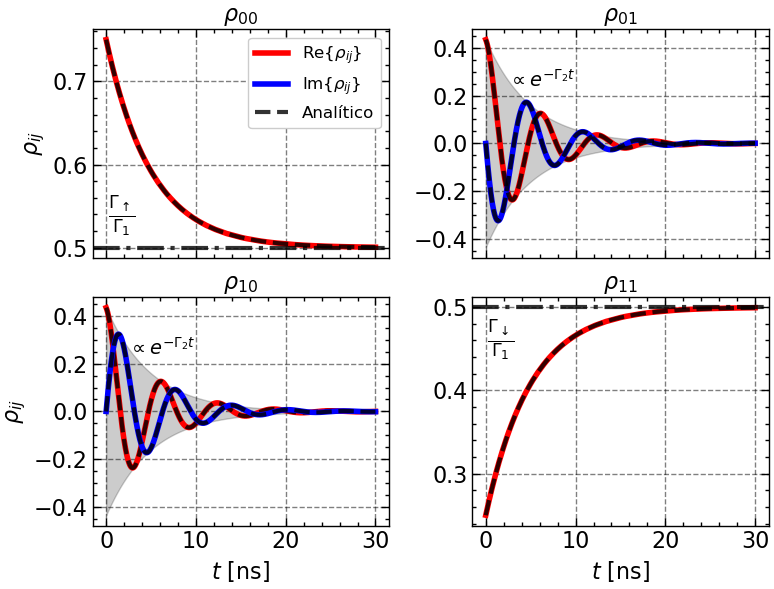

In [135]:
time_axis = np.arange(time_limits_x_plus_red[0], time_limits_x_plus_red[1]+h_x_plus_red, h_x_plus_red)


up_decay = lambda t, pee: pee * np.exp(-gamma_minus * t)    # Solución analítica para el elemento 0,0 de la matriz de densidad (proba de que este en excitado)
down_decay = lambda t, pee: 1 - up_decay(t, pee)            # Solución analítica para el elemento 1,1 de la matriz de densidad (proba de que este en el estado base)
coherence_decay = lambda t, p01, omega_q: p01 * np.exp(-gamma_minus/2 * t) * np.exp(1j *omega_q * t) 

up_decay_term = lambda t, pee, gamma_min, gamma_plus: pee * np.exp(-(gamma_min + gamma_plus) * t) + gamma_plus/(gamma_plus + gamma_minus) * (1 - np.exp(-(gamma_plus + gamma_minus) * t))
down_decay_term = lambda t, pee, gamma_min, gamma_pls: 1 - up_decay_term(t, pee, gamma_min, gamma_pls)

coherence_decay_term = lambda t, p01, omega_q, gamma_minus, gamma_plus, gamma_phi: p01 * np.exp(-1j * omega_q * t) * np.exp(-((gamma_minus + gamma_plus)/2 + gamma_phi) * t) 

p_exc_r = states_x_plus_red[:,0,0]
p_gnd_r = states_x_plus_red[:,1,1]
p_01_r = states_x_plus_red[:, 0,1]
p_10_r = states_x_plus_red[:, 1,0]


fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

ax[0, 0].plot(time_axis, p_exc_r, color='red', lw=4)
ax[0, 0].plot(time_axis, up_decay_term(time_axis, p_exc_r[0], gamma_minus, gamma_plus), linestyle='--', color='black', alpha=0.8, lw=3)
ax[0,0].axhline((gamma_plus/(gamma_plus + gamma_minus)), linestyle='-.', color='black', alpha=0.8, lw=3)
ax[0,0].text(0.05, 0.15, r'$\frac{\Gamma_\uparrow}{\Gamma_1}$', transform=ax[0,0].transAxes, fontsize=18, color='black')


ax[0, 1].plot(time_axis, p_01_r.real, label=r'$\text{Re} \{\rho_{ij}\}$', color='red', lw=4)
ax[0, 1].plot(time_axis, p_01_r.imag, label=r'$\text{Im}\{\rho_{ij}\}$', color='blue', lw=4)
ax[0, 1].plot(time_axis, coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus, gamma_phi).real, label=r'Analítico', linestyle='--', color='black', alpha=0.8, lw=3)
ax[0, 1].plot(time_axis, coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus, gamma_phi).imag, linestyle='--', color='black', alpha=0.8, lw=3)

envolvente = np.abs(coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus, gamma_phi))

ax[0, 1].fill_between(time_axis, -envolvente, envolvente, color='black', alpha=0.2)
ax[0, 1].text(0.12, 0.75, r'$\propto e^{-\Gamma_2 t}$', transform=ax[0,1].transAxes, fontsize=14, color='black')


ax[1, 0].plot(time_axis, p_10_r.real, color='red', lw=4)
ax[1, 0].plot(time_axis, coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus, gamma_phi).real, linestyle='--', color='black', alpha=0.8, lw=3)
ax[1, 0].plot(time_axis, p_10_r.imag, color='blue', lw=4)
ax[1, 0].plot(time_axis, coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus, gamma_phi).conj().imag,  linestyle='--', color='black', alpha=0.8, lw=3)

envolvente = np.abs(coherence_decay_term(time_axis, p_01_r[0], omega_q, gamma_minus, gamma_plus, gamma_phi))

ax[1, 0].fill_between(time_axis, -envolvente, envolvente, color='black', alpha=0.2)
ax[1, 0].text(0.12, 0.75, r'$\propto e^{-\Gamma_2 t}$', transform=ax[1,0].transAxes, fontsize=14, color='black')


ax[1, 1].plot(time_axis, p_gnd_r,  color='red', lw=4)
ax[1, 1].plot(time_axis, down_decay_term(time_axis, p_exc_r[0], gamma_minus, gamma_plus), linestyle='--', color='black', alpha=0.8, lw=3)
ax[1, 1].axhline((gamma_minus/(gamma_plus + gamma_minus)), linestyle='-.', color='black', alpha=0.8, lw=3)
ax[1, 1].text(0.05, 0.78, r'$\frac{\Gamma_\downarrow}{\Gamma_1}$', transform=ax[1,1].transAxes, fontsize=18, color='black')

handles, labels = ax[0, 1].get_legend_handles_labels()
ax[0, 0].legend(handles, labels, fontsize=12)

print(labels)

print(labels)


for i in range(2):
    for j in range(2):
        ax[i, j].set_title(r"$\rho_{%d%d}$" % (i, j))

        if i == 1:
            ax[i, j].set_xlabel(r'$t$ [ns]')
        if j == 0:
            ax[i, j].set_ylabel(r'$\rho_{ij}$')

plt.tight_layout()
plt.savefig('../doc/figures/psi_relx_exc_desf.pdf', dpi=500)